# Scaling   Black-box attack

In [34]:
import warnings
warnings.filterwarnings("ignore")

Firstly, we import the required libraries.

In [35]:
import tensorflow as tf
import tensorflow_constrained_optimization as tfco
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
import cv2
import numpy as np
import argparse
from pathlib import Path
from matplotlib import pyplot as plt
import os
import sys

In the following function we define the functionality of the scaling attack.

In [36]:
# Delete debug TF messages
"""
    0 = all messages are logged (default behavior)
    1 = INFO messages are not printed
    2 = INFO and WARNING messages are not printed
    3 = INFO, WARNING, and ERROR messages are not printed
"""
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 


class Problem(tfco.ConstrainedMinimizationProblem):
  def __init__(self, S, T, method, epsilon):
    self._delta = tf.Variable(tf.expand_dims(tf.ones(shape=S.shape, dtype=tf.float32), axis=0), trainable=True, name="delta")
    self._S = tf.expand_dims(tf.convert_to_tensor(S, dtype=tf.float32) / 255, axis=0)
    self._T = tf.expand_dims(tf.convert_to_tensor(T, dtype=tf.float32) / 255, axis=0)
    self._method = method
    self._epsilon= epsilon
    self._delta_shape = self._S.shape
    self._main_constraint = 0
    self._n_constraints = self._T.shape[0] * self._T.shape[1] * self._T.shape[2] * self._T.shape[3] * 2 + 1
  
  @property
  def num_constraints(self):
    return self._n_constraints
  
  def objective(self):
    return tf.norm(self._delta, ord='euclidean')
  
  def constraints(self):
    D = tf.image.resize(self._S + self._delta, size=[self._T.shape[1], self._T.shape[2]], method=self._method)
    main_contraint = tf.norm((D - self._T), ord='euclidean') - self._epsilon
    self._main_constraint = main_contraint
    main_contraint = tf.reshape(main_contraint, shape=(1,1))
    gt_or_eq_to_zero= tf.reshape(-D, shape=(D.shape[0] * D.shape[1] * D.shape[2] * D.shape[3], 1))
    lt_or_eq_to_1= tf.reshape(D - 1, shape=(D.shape[0] * D.shape[1] * D.shape[2] * D.shape[3], 1))

    constraints = tf.concat([main_contraint, gt_or_eq_to_zero, lt_or_eq_to_1], axis=0)
    constraints = tf.reshape(constraints, shape=(constraints.shape[0]))
    return constraints


def optimize(S, T, method, epsilon, iterations):
  problem = Problem(S, T, method, epsilon)

  optimizer = tfco.LagrangianOptimizerV2(
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),
    num_constraints=problem.num_constraints
  )

  tfco.RateMinimizationProblem
  var_list = [problem._delta, optimizer.trainable_variables()]

  for i in range(iterations):

    optimizer.minimize(problem, var_list=var_list)
    
    if i % 1000 == 0:
      print(f'[*] Step = {i}')
      print("\t\t[*] Modification size: ", problem.objective().numpy())
      print("\t\t[*] Difference between the modified image (A) and target image: ", problem._main_constraint.numpy())


  # Modified image
  A = problem._S[0] + problem._delta[0]

  return A

Now it is time to choose the pair of images to be used for the scaling attack.

In [43]:
# Example of an image that a company could predict with its model. 
# We can really use any image, it doesn't matter if it has to look like one that the company's model can use.
# Source image (S)
source_path = 'stop_signal.jpg' 

# This is the image that will appear after performing the scaling attack.
# In this way we can trick a model into actually predicting this image.
# Target image (T)
target_path = 'no_stop_signal.jpg' 

In [44]:
def show_image(image_path):
    img = image.load_img(image_path)
    img_tensor = image.img_to_array(img)
    img_tensor /= 255
    plt.imshow(img_tensor)
    print(img_tensor.shape)

(1775, 2048, 3)


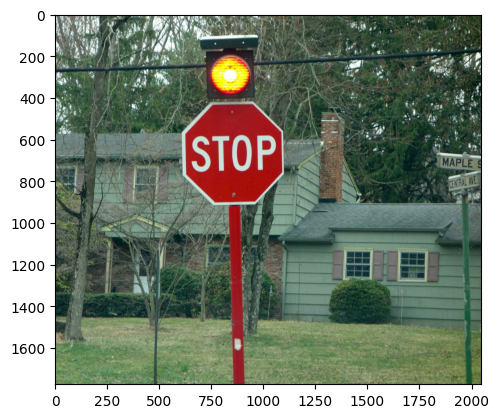

In [45]:
# Source image (S)

show_image(source_path)

(400, 600, 3)


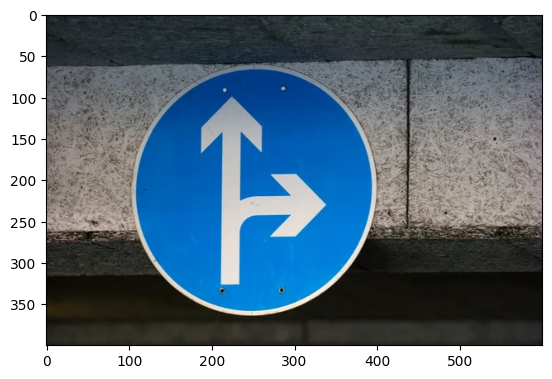

In [46]:
# Target image (T)

show_image(target_path)

In [47]:
def load_image(tam):
  img = image.load_img(source_path,target_size=(tam,tam))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  
  return img_tensor

With this script we try to find out the image size that the company uses to train its models and we do a scaling attack to check which interpolation algorithms it is vulnerable to.

Attacking the model... trying to find out the size of model inputs...

1/1 [==============================] - 0s 95ms/step
--- The shape of their model inputs is (224, 224, 3) --- 

Now checking interpolation method...

CHOICE ---> bilinear

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.29697
[*] Step = 1000
		[*] Modification size:  2923.1125
		[*] Difference between the modified image (A) and target image:  22.052984
[*] Step = 2000
		[*] Modification size:  2610.1611
		[*] Difference between the modified image (A) and target image:  0.04017531
[*] Step = 3000
		[*] Modification size:  2296.7695
		[*] Difference between the modified image (A) and target image:  0.04059919


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


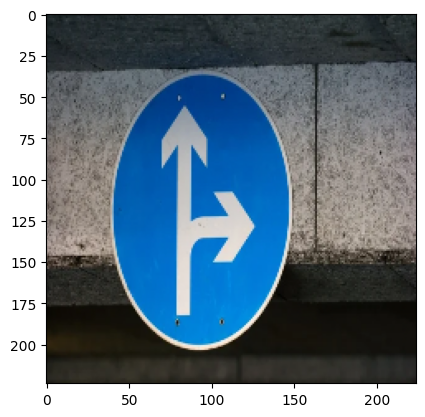

1/1 [==============================] - 0s 28ms/step

This is a no_stop signal.

-----------------

CHOICE ---> lanczos3

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.37857
[*] Step = 1000
		[*] Modification size:  2975.3018
		[*] Difference between the modified image (A) and target image:  0.07945631
[*] Step = 2000
		[*] Modification size:  2663.2302
		[*] Difference between the modified image (A) and target image:  0.080396734
[*] Step = 3000
		[*] Modification size:  2351.742
		[*] Difference between the modified image (A) and target image:  0.087435625


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


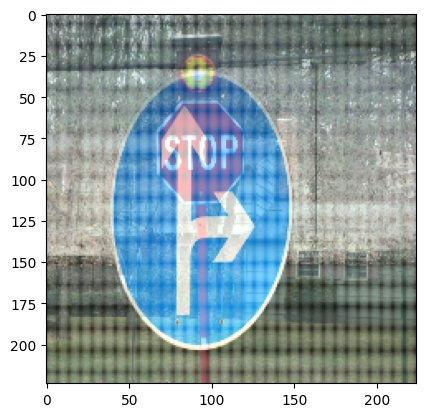

1/1 [==============================] - 0s 22ms/step

This is a no_stop signal.

-----------------

CHOICE ---> lanczos5

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.37555
[*] Step = 1000
		[*] Modification size:  2978.491
		[*] Difference between the modified image (A) and target image:  0.12332023
[*] Step = 2000
		[*] Modification size:  2667.6792
		[*] Difference between the modified image (A) and target image:  0.119285874
[*] Step = 3000
		[*] Modification size:  2357.5771
		[*] Difference between the modified image (A) and target image:  0.11086119


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


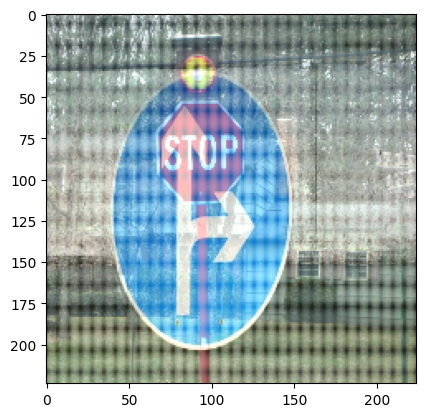

1/1 [==============================] - 0s 24ms/step

This is a no_stop signal.

-----------------

CHOICE ---> bicubic

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.3613
[*] Step = 1000
		[*] Modification size:  2963.2417
		[*] Difference between the modified image (A) and target image:  0.11999457
[*] Step = 2000
		[*] Modification size:  2649.4177
		[*] Difference between the modified image (A) and target image:  0.099452086
[*] Step = 3000
		[*] Modification size:  2336.061
		[*] Difference between the modified image (A) and target image:  0.07242536


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


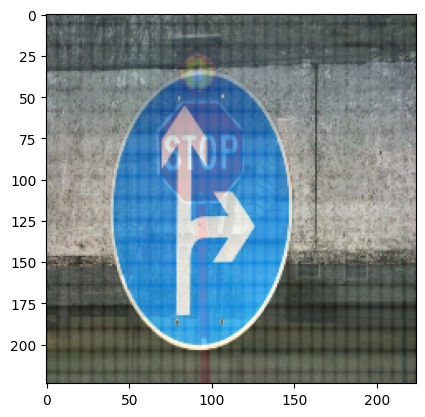

1/1 [==============================] - 0s 26ms/step

This is a no_stop signal.

-----------------

CHOICE ---> gaussian

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.26624
[*] Step = 1000
		[*] Modification size:  2893.942
		[*] Difference between the modified image (A) and target image:  41.910854
[*] Step = 2000
		[*] Modification size:  2581.652
		[*] Difference between the modified image (A) and target image:  0.034034707
[*] Step = 3000
		[*] Modification size:  2269.4795
		[*] Difference between the modified image (A) and target image:  0.018539548


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


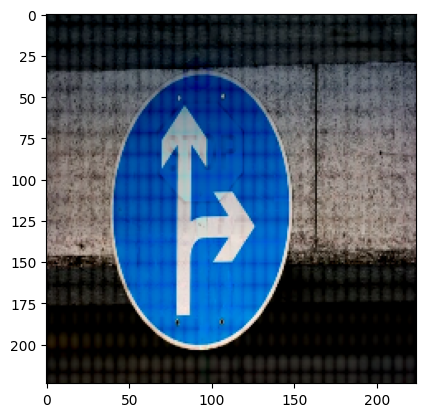

1/1 [==============================] - 0s 31ms/step

This is a stop signal.

-----------------

CHOICE ---> nearest

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.3618
[*] Step = 1000
		[*] Modification size:  2965.9275
		[*] Difference between the modified image (A) and target image:  0.19899544
[*] Step = 2000
		[*] Modification size:  2650.538
		[*] Difference between the modified image (A) and target image:  0.11997729
[*] Step = 3000
		[*] Modification size:  2335.4822
		[*] Difference between the modified image (A) and target image:  0.07904386


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


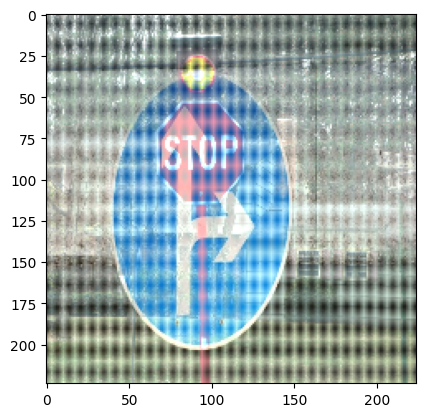

1/1 [==============================] - 0s 22ms/step

This is a no_stop signal.

-----------------

CHOICE ---> mitchellcubic

[*] Step = 0
		[*] Modification size:  3302.0466
		[*] Difference between the modified image (A) and target image:  417.31693
[*] Step = 1000
		[*] Modification size:  2936.3264
		[*] Difference between the modified image (A) and target image:  9.724718
[*] Step = 2000
		[*] Modification size:  2623.0068
		[*] Difference between the modified image (A) and target image:  0.061400674
[*] Step = 3000
		[*] Modification size:  2309.6162
		[*] Difference between the modified image (A) and target image:  0.038243376


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


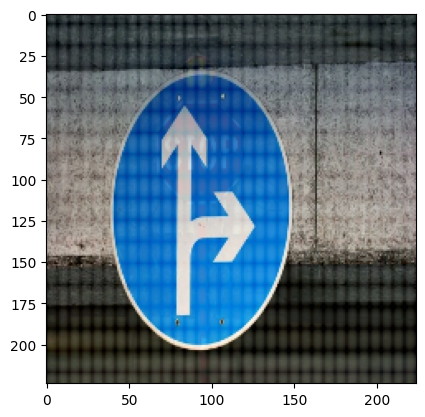

1/1 [==============================] - 0s 20ms/step

This is a no_stop signal.

-----------------



In [48]:
print("Attacking the model... trying to find out the size of model inputs...\n")

for size in range(1,2000):

  model = tf.keras.models.load_model('traffic_sign.keras')
  image_tensor = load_image(size)
  
  try:

    preds = model.predict(image_tensor)

  except:

    continue
  
  break


attack_shape = image_tensor.shape[1:]

print(f"--- The shape of their model inputs is {attack_shape} --- \n")

print("Now checking interpolation method...\n")


# We start the scaling attack. 
# We have the source image (S), which when rescaled to the found size will change its appearance 
# and take the appearance of the target image (T). 

S = cv2.cvtColor(cv2.imread(source_path, 1), cv2.COLOR_BGR2RGB)
T = cv2.cvtColor(cv2.imread(target_path, 1), cv2.COLOR_BGR2RGB)

T = cv2.resize(T, (attack_shape[0], attack_shape[1])) 

choices = ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'gaussian', 'nearest','mitchellcubic']

chosen = []
class_names=['no_stop','stop']

for choice in choices:

  print(f"CHOICE ---> {choice}\n")

  A = optimize(S, T, choice, 0.1, 4000)
  D = tf.image.resize(tf.expand_dims(A, axis=0), size=[T.shape[0], T.shape[1]])[0]

  D_expanded = np.expand_dims(D, axis=0)
  D_expanded = D_expanded*255
  D_expanded = D_expanded.astype(np.uint8)/1

  plt.imshow(D)
  plt.show()

  prediction = model.predict(D_expanded)
  prediction = np.argmax(prediction)

  print()
  print(f"This is a {class_names[prediction]} signal.\n")

  if class_names[prediction] == 'no_stop': chosen.append(choice)
  

  print("-----------------\n")

In [49]:
print(f"The model is vulnerable to size {attack_shape} and methods of interpolation {chosen}")

The model is vulnerable to size (224, 224, 3) and methods of interpolation ['bilinear', 'lanczos3', 'lanczos5', 'bicubic', 'nearest', 'mitchellcubic']
